In [1]:
### Importing all the neccessary packages ###
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy
from matplotlib.offsetbox import AnchoredText
import cartopy.feature as cfeature
import scipy.fft as sf
from scipy import signal
from scipy.stats import circmean
from scipy import optimize
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import intake
import pathlib

import seasonality.seasonalityfunctions as sf
import seasonality.onset_demise as od

In [2]:
### Bombardi et al., 2019 has put the code on github under the MIT license, which allows us to utilize their code in any way we see fit. 
### We will of course credit Bombardi et al., 2019 in the eventual manuscript.

In [3]:
### Allows us to use dask to speed up some calculations ###
from dask.distributed import Client
client = Client()


In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61295,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:61306,Total threads: 2
Dashboard: http://127.0.0.1:61312/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:61298,


In [365]:
from importlib import reload
reload(sf)

<module 'seasonality.seasonalityfunctions' from '/Users/gbromley/code/PrecipitationSeasonality/seasonality/seasonalityfunctions.py'>

In [332]:
test_data = np.array([120,180,270,360])


180.00000000000003

In [188]:
catalog_url = 'https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json'
col = intake.open_esm_datastore(catalog_url)

col_subset = col.search(frequency=["daily"], component="atm", variable="PRECT",
                        experiment=["20C", "RCP85", "HIST"])

dsets = col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True}, storage_options={"anon": True})
print(f"\nDataset dictionary keys:\n {dsets.keys()}")

ds_20C = dsets['atm.20C.daily']['PRECT']

test = ds_20C.sel(lat=46,lon=-105+360,member_id=105, method="nearest").compute()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


/var/folders/m4/3slgbrxj3z3dm65l82539j6w0000gq/T/ipykernel_84229/1179976266.py:7: DeprecationWarning: cdf_kwargs and zarr_kwargs are deprecated and will be removed in a future version. Please use xarray_open_kwargs instead.
  dsets = col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True}, storage_options={"anon": True})



Dataset dictionary keys:
 dict_keys(['atm.HIST.daily', 'atm.20C.daily', 'atm.RCP85.daily'])


In [349]:
import pathlib
file = pathlib.Path('')

if not file.exists():
    

    catalog_url = 'https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json'
    col = intake.open_esm_datastore(catalog_url)

    col_subset = col.search(frequency=["daily"], component="atm", variable="PRECT",
                            experiment=["20C", "RCP85", "HIST"])

    dsets = col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True}, storage_options={"anon": True})
    print(f"\nDataset dictionary keys:\n {dsets.keys()}")

    ds_20C = dsets['atm.20C.daily']['PRECT']
    
    test = ds_20C.sel(lat=46,lon=-105+360,member_id=105, method="nearest").compute()

else:
    test = xr.open_dataset("test_cesm.nc")

In [350]:
test

<xarray.Dataset>
Dimensions:    (time: 31390)
Coordinates:
    lat        float64 ...
    lon        float64 ...
    member_id  int64 ...
  * time       (time) object 1920-01-01 12:00:00 ... 2005-12-31 12:00:00
Data variables:
    PRECT      (time) float32 ...

In [351]:
dr = pd.date_range('1920-01-01','2005-12-31', freq='1D')
dates_noleap = dr[(dr.day != 29) | (dr.month != 2)]

test['time'] = dates_noleap
#test = test.sel(time=slice('1996','1998'))
# Renaming datarray to match existing code and changeing from m/s to m
ds_subset = test.rename({'PRECT':'precip'})*86400.0
### Changing data to mm and removing leap days ###
precip = ds_subset['precip']*1000.0
precip = precip.sel(time=~((precip.time.dt.month == 2) & (precip.time.dt.day == 29)))

### Calculating the mean precipitation for each grid point
annual_mean_precip = precip.mean(dim='time')

### Calculating the mean annual cycle ###
annual_precip_cycle= precip.groupby('time.dayofyear').mean(dim='time')

# Pandas creates leap day again with dayofyear use here
annual_precip_cycle = annual_precip_cycle[annual_precip_cycle.dayofyear != 60]
annual_precip_cycle['dayofyear'] = np.arange(1,365+1,1)

annual_precip_cycle_var = precip.groupby('time.dayofyear').std(dim='time')

# Pandas creates leap day again with dayofyear use here
annual_precip_cycle_var = annual_precip_cycle_var[annual_precip_cycle_var.dayofyear != 60]
annual_precip_cycle_var['dayofyear'] = np.arange(1,365+1,1)

### Create Daily precip from hourly ###
##daily_precip = precip.resample(time='1D').sum()

### Create The annual daily precip anomalies ###
annual_means = precip.groupby('time.year').mean(dim='time')


anomalies = precip.groupby('time.year') - annual_means
#anomalies = anomalies_withleap.sel(time=~((anomalies_withleap.time.dt.month == 2) & (anomalies_withleap.time.dt.day == 29)))

climDailyMeanAnomaly = annual_precip_cycle - annual_mean_precip

In [352]:
### Use dask to run the Harmonics finction over the data ### 
# Slightly faster than a loop but still slow ###

start_wet3 = xr.apply_ufunc(
    od.B17_analysis_start,
    annual_precip_cycle,
    input_core_dims=[["dayofyear"]],
    exclude_dims=set(["dayofyear"]),
    vectorize=True,
    dask='parallized',
    output_dtypes=[annual_precip_cycle.dtype]
).values


In [353]:
start_wet3

array(354., dtype=float32)

In [355]:
array_jday = anomalies.time.dt.dayofyear
input_data = anomalies.assign_coords(jday=("time",array_jday.data))

In [356]:
days = np.array(pd.DatetimeIndex(input_data.time).dayofyear)


In [357]:
years = np.array(pd.DatetimeIndex(input_data.time).year)

In [358]:
data = input_data.values

In [359]:
years_ = np.unique(test_index)

In [440]:
test_doy = np.array([350, 355, 364,1,3,4])
#test_doy = od.onset_LM01(data, days, years, start_wet3)

In [407]:
test_outliers = test_doy - sf.median_doy(test_doy)

In [408]:
test_outliers

array([-1.39977736e+01, -8.99777363e+00,  2.22636941e-03, -3.62997774e+02,
       -3.60997774e+02, -3.59997774e+02, -1.43997774e+02])

In [441]:
np.is sf.check_outliers(test_doy, threshold=1.5)

array([], dtype=int64)

In [401]:
test_doy[np.isnan(test_doy)] = np.ma.masked
#np.any(test_doy < 0)

In [410]:
np.nanpercentile(test_outliers,25)

-360.497773630592

In [411]:
np.nanpercentile(test_outliers,75)

-11.497773630592008

In [413]:
sf.check_outliers(test_doy, threshold=1.5)

array([], dtype=int64)

In [383]:
np.nanpercentile(test_outliers,25)

-18.223071717537422

In [438]:
reload(sf)

<module 'seasonality.seasonalityfunctions' from '/Users/gbromley/code/PrecipitationSeasonality/seasonality/seasonalityfunctions.py'>

In [430]:
iqr = np.nanpercentile(tmpc,75) - np.nanpercentile(tmpc,25)

In [417]:
sf.median_doy(test_doy)

363.997773630592

In [423]:
np.set_printoptions(suppress=True)
test_outliers

array([ -13.99777363,   -8.99777363,    0.00222637, -362.99777363,
       -360.99777363, -359.99777363, -143.99777363])

In [419]:
iqr

349.0

In [425]:
test_outliers

array([ -13.99777363,   -8.99777363,    0.00222637, -362.99777363,
       -360.99777363, -359.99777363, -143.99777363])

In [427]:
365* -.5

-182.5

In [431]:
np.where(np.abs(tmpc) > iqr*1.5)[0]

array([6])

In [437]:
tmpc[np.where(np.abs(tmpc) > iqr*1.5)[0]]

array([-143.99777363])

In [439]:
sf.check_outliers(test_doy)

array([6])

In [422]:
tot=365
tmpc = test_doy - sf.median_doy(test_doy)
pos=np.where(tmpc[:] > float(tot)*0.5)[0]
if len(pos) > 0:
    print('1')
    tmpc[pos]=tmpc[pos]-tot
neg=np.where(tmpc[:] < float(tot)*(-0.5))[0]
if len(neg) > 0:
    print(2)
    tmpc[neg]=tmpc[neg]+tot

2


In [428]:
tmpc

array([ -13.99777363,   -8.99777363,    0.00222637,    2.00222637,
          4.00222637,    5.00222637, -143.99777363])

In [185]:
def test_B17(data, days, years, startWet):
    
    """
    Summary:
    --------
    Calculates the start of a wet season using the Bombardi et al., 2017 methods. 
    
    Input:
    ------
        data: Daily precipitation anomalies.
        days: Numpy array of day of year (1-365), no leap.
        years: Numpy array of year for each item in days.
        startWet: The doy for when to start the cumulative sum calcuation.
    
    Output:
    -------
        onsetDOY: Array of onset dates. Length is the same as the number of years on input data.

    
    """
    # TODO move lines 206-250 to seperate class or function
    if len(days) != len(years):
        raise ValueError('Length of days and years must be the same.')
        
    # Want to make sure we get all the input years before any trimming
    unique_years = np.unique(years)
    
    onsetDOY = np.empty((len(unique_years)))
    onsetDOY[:] = np.nan
    


    # Day of year is missing integer 60 which is February 29th.
    # Need to add zero because a tuple is returned from np.where
    temp_start_index = np.where(days == startWet)[0]
    print(temp_start_index)
    #print(len(data))
    # double check we have enough data for last onset calculation
    if len(days[temp_start_index[-1]:]) < 180:
        #print(temp_start_index[0],temp_start_index[-1])
        # trim off data we can't use
        data_trimmed = data[temp_start_index[0]:temp_start_index[-1]]
        days_trimmed = days[temp_start_index[0]:temp_start_index[-1]]
        years_trimmed = years[temp_start_index[0]:temp_start_index[-1]]
    else:
        data_trimmed = data
        days_trimmed = days
        years_trimmed = years
    #print(days_trimmed)
    #print(years_trimmed)       
    # Reindex start days with trimmed days  
    # Need to add zero because a tuple is returned from np.where
    start_day_index = np.where(days_trimmed == startWet)[0]
    #print(data_trimmed)
    ### looping through start dates ###
    for start_day in start_day_index:
        
        # Make analysis period 180 days in length. 
        #TODO #check that 180 days matters
        analysis_begin = start_day
        analysis_end = start_day + 180
        
        analysis_days = days_trimmed[analysis_begin:analysis_end]
        analysis_years = years_trimmed[analysis_begin:analysis_end]
        
        cumsum_data = np.cumsum(data_trimmed[analysis_begin:analysis_end])
        
        #smoothed_cs_data = sf.smooth_B17(cumsum_data)
        
        deriv = np.gradient(cumsum_data)
        #print(deriv)
        window=6
        # Numpy function that returns the sign of each element
        # -1 if negative, 0 if 0, 1 if positive
        sign_array = np.sign(deriv)
    
    
    
    
        # build up the inflection window
        inflection_array = np.ones(window)
    
        # Finding the middle of the window, rounded down if odd.
        split = int(np.floor(window/2))
    
        # Make first half -1
        inflection_array[:split] = -1
        
        print(inflection_array)
        testing = np.lib.stride_tricks.sliding_window_view(sign_array,window)
        #print(testing[:6])
        result = np.where(np.all(testing== inflection_array, axis=1))
        #print(result[0][0])
        onset_index = result[0][0]
        
        
        # this returns the index of the data not the day
        print(result[0])
        
        onset_day = analysis_days[onset_index]
        onset_year = analysis_years[onset_index]
        #print(analysis_years)
        #print(onset_day)
        where_to_place = np.argwhere(unique_years == onset_year)[0][0]
        onsetDOY[where_to_place] = onset_day
        
    return onsetDOY
    

In [176]:
days = time_onset
years = test_index
startWet=354
temp_start_index = np.where(days == startWet)[0]
print(temp_start_index)
#print(len(data))
# double check we have enough data for last onset calculation
if len(days[temp_start_index[-1]:]) < 180 and 365-len(days[:temp_start_index[0]]):
    #print(temp_start_index[0],temp_start_index[-1])
    # trim off data we can't use
    data_trimmed = data[temp_start_index[0]:temp_start_index[-1]]
    days_trimmed = days[temp_start_index[0]:temp_start_index[-1]]
    years_trimmed = years[temp_start_index[0]:temp_start_index[-1]]
else:
    data_trimmed = data
    days_trimmed = days
    years_trimmed = years
#print(days_trimmed)
#print(years_trimmed)       
# Reindex start days with trimmed days  
# Need to add zero because a tuple is returned from np.where
start_day_index = np.where(days_trimmed == startWet)[0]
print(start_day_index)
print(years_trimmed[start_day_index])

[ 352  718 1083]
[  0 366]
[1996 1997]


In [184]:
analysis_begin = 0
analysis_end = 180

#analysis_days = days_trimmed[analysis_begin:analysis_end]
#analysis_years = years_trimmed[analysis_begin:analysis_end]

#cumsum_data = np.cumsum(data_trimmed[analysis_begin:analysis_end])

test_cumsum = np.cumsum(data_trimmed[analysis_begin:analysis_end])
smoothed_cs_data = sf.smooth_B17(test_cumsum)
test_deriv = np.gradient(test_cumsum)
test_sign = np.sign(test_deriv)
window=6
# build up the inflection window
inflection_array = np.ones(window)

# Finding the middle of the window, rounded down if odd.
split = int(np.floor(window/2))

# Make first half -1
inflection_array[:split] = -1

testing = np.lib.stride_tricks.sliding_window_view(test_sign,window)
#print(testing)
print(inflection_array)
result = np.where(np.all(testing == inflection_array, axis=1))
print(result[0])
#onset_index = result[0][0]




[-1. -1. -1.  1.  1.  1.]
[  4 131]


In [180]:
start_day_index=[0]
for start_day in start_day_index:
        
        # Make analysis period 180 days in length. 
        #TODO #check that 180 days matters
        analysis_begin = start_day
        analysis_end = start_day + 180
        
        analysis_days = days_trimmed[analysis_begin:analysis_end]
        analysis_years = years_trimmed[analysis_begin:analysis_end]
        
        cumsum_data = np.cumsum(data_trimmed[analysis_begin:analysis_end])
        
        smoothed_cs_data = sf.smooth_B17(cumsum_data)
        
        deriv = np.gradient(smoothed_cs_data)
        #print(deriv)
        window=6
        # Numpy function that returns the sign of each element
        # -1 if negative, 0 if 0, 1 if positive
        sign_array = np.sign(deriv)
    
    
    
    
        # build up the inflection window
        inflection_array = np.ones(window)
    
        # Finding the middle of the window, rounded down if odd.
        split = int(np.floor(window/2))
    
        # Make first half -1
        inflection_array[:split] = -1
        
        print(inflection_array)
        testing = np.lib.stride_tricks.sliding_window_view(sign_array,window)
        #print(testing[:6])
        result = np.where(np.all(testing== inflection_array, axis=1))
        #print(result[0][0])
        onset_index = result[0][0]
        
        
        # this returns the index of the data not the day
        print(result[0])

[-1. -1. -1.  1.  1.  1.]
[  4 131]


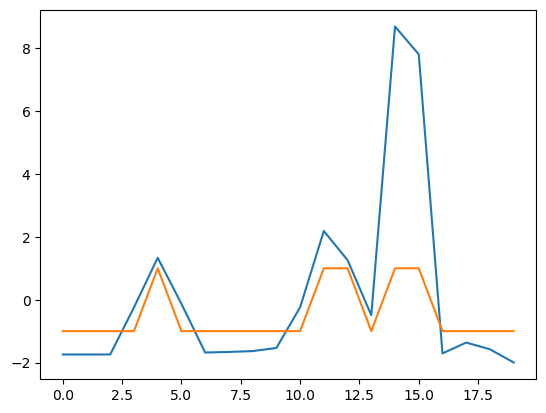

In [140]:
#plt.plot(np.cumsum(data[352:352+100]))
#plt.plot(sf.smooth_B17(test_cumsum))
plt.plot(test_deriv[0:20])
plt.plot(test_sign[0:20])

In [186]:
test_B17(data,time_onset,test_index, 354)

[ 352  718 1083]
[-1. -1. -1.  1.  1.  1.]
[135 157]
[-1. -1. -1.  1.  1.  1.]
[108 120 137 172]


array([ nan, 123.,  97.])

In [144]:
test_lm01[76]


112.0

In [15]:
test_b17 = od.onset_B17(data,time_onset,test_index, 354)

In [18]:
data

array([  nan,    4.,    1.,   70.,    4.,    5.,    5.,    7.,    6.,
        115.,    4.,   70.,    3.,    6.,   11.,  105.,   84.,    3.,
         59.,    7.,   46.,   34.,   26.,    7.,    4.,    3.,   48.,
          5.,    9.,    3.,   39.,   39.,    2.,    1.,   36.,   50.,
          3.,   26.,   45.,    3.,    4.,   49.,  100.,   33.,    6.,
         65.,   36.,    1.,    5.,    3.,    5.,   64.,   32.,   28.,
          2.,   39.,    6.,    7.,   61.,    2.,    6.,   93.,   42.,
          1.,    6.,   39.,    4.,   78.,   22.,    1.,  123.,   56.,
          1.,    7.,    8.,    5., -247.,   nan,    3.,   19.,   67.,
          5.,   42.,    8.,    5.,   25.])

In [24]:
np.argwhere(np.isnan(test_b17))

array([[ 0],
       [77]])

In [27]:
years_[77]

1997

In [152]:
onset_date = np.array([pd.to_datetime(i, format='%Y') + pd.Timedelta(k, unit='D') for i,k in zip(years_,test_onset_output)])

In [12]:
od.onset_B17(data[::-1],time_onset[::-1],test_index[::-1], 354)

array([316., 286., 303., 338., 266., 264., 281., 263., 292., 309., 333.,
       268., 271., 312., 243., 324., 278., 264., 258., 272., 303., 276.,
       317., 240., 306., 337., 315., 282., 323., 316., 305., 331., 309.,
       298., 301., 297., 288., 269., 275., 226., 314., 281., 341., 289.,
       224., 228., 320., 334., 258., 318., 266., 315., 330., 302., 288.,
       270., 323., 263., 335., 284., 282., 279., 265., 335., 311., 302.,
       314., 296., 295., 314., 278., 294., 294., 314., 318., 307., 271.,
       244., 256., 309., 300., 322., 328., 303., 336., 280.])

In [233]:
onset_LM01(data[::-1],time_onset[::-1],test_index[::-1], 354) == demise_LM01(data,time_onset,test_index,354)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [234]:
demise_LM01(data,time_onset,test_index,354)

array([293., 276., 251., 274., 264., 257., 278., 211., 245., 224., 279.,
       263., 214., 256., 203., 321., 243., 264., 258., 264., 237., 273.,
       276., 239., 271., 253., 276., 274., 240., 268., 193., 261., 252.,
       271., 293., 249., 200., 263., 270., 231., 249., 276., 244., 213.,
       224., 224., 320., 265., 256., 257., 258., 308., 294., 235., 281.,
       267., 319., 262., 247., 278., 230., 253., 263., 233., 223., 210.,
       247., 222., 235., 307., 270., 249., 227., 263., 224., 213., 264.,
       241., 186., 301., 219., 242., 321., 206., 235., 269.])

In [235]:
onset_LM01(data[::-1],time_onset[::-1],test_index[::-1], 354)

array([293., 276., 251., 274., 264., 257., 278., 211., 245., 224., 279.,
       263., 214., 256., 203., 321., 243., 264., 258., 264., 237., 273.,
       276., 239., 271., 253., 276., 274., 240., 268., 193., 261., 252.,
       271., 293., 249., 200., 263., 270., 231., 249., 276., 244., 213.,
       224., 224., 320., 265., 256., 257., 258., 308., 294., 235., 281.,
       267., 319., 262., 247., 278., 230., 253., 263., 233., 223., 210.,
       247., 222., 235., 307., 270., 249., 227., 263., 224., 213., 264.,
       241., 186., 301., 219., 242., 321., 206., 235., 269.])

In [236]:
demise_LM01(data[::-1],time_onset[::-1],test_index[::-1],354)

array([ nan, 114., 101., 140.,  76.,  74.,  76.,  78.,  61., 120.,  94.,
       121.,  97., 107., 103., 155.,  92.,  73.,  94., 109.,  87., 115.,
       125.,  85., 115.,  74., 120.,  84.,  81., 102.,  84., 106.,  83.,
        78., 136., 115.,  96.,  94., 117.,  85., 103., 146., 104., 100.,
        78., 126., 119.,  89., 101.,  92.,  72.,  80., 127., 120.,  80.,
       125.,  74., 113., 142.,  56.,  99., 117.,  91.,  83., 108., 101.,
       107., 110.,  93.,  78., 137., 128., 102.,  94., 121., 105., 112.,
       126.,  70., 109.,  78.,  82., 118.,  70., 109.,  85.])

In [238]:
onset_LM01(data,time_onset,test_index,354) == demise_LM01(data[::-1],time_onset[::-1],test_index[::-1],354)

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [31]:
#demise_dates = np.array([pd.to_datetime(i, format='%Y') + pd.Timedelta(k, unit='D') for i,k in zip(years_,test_demise_output#)])
onset_dates = np.array([pd.to_datetime(i, format='%Y') + pd.Timedelta(k, unit='D') for i,k in zip(years_,test_lm01)])

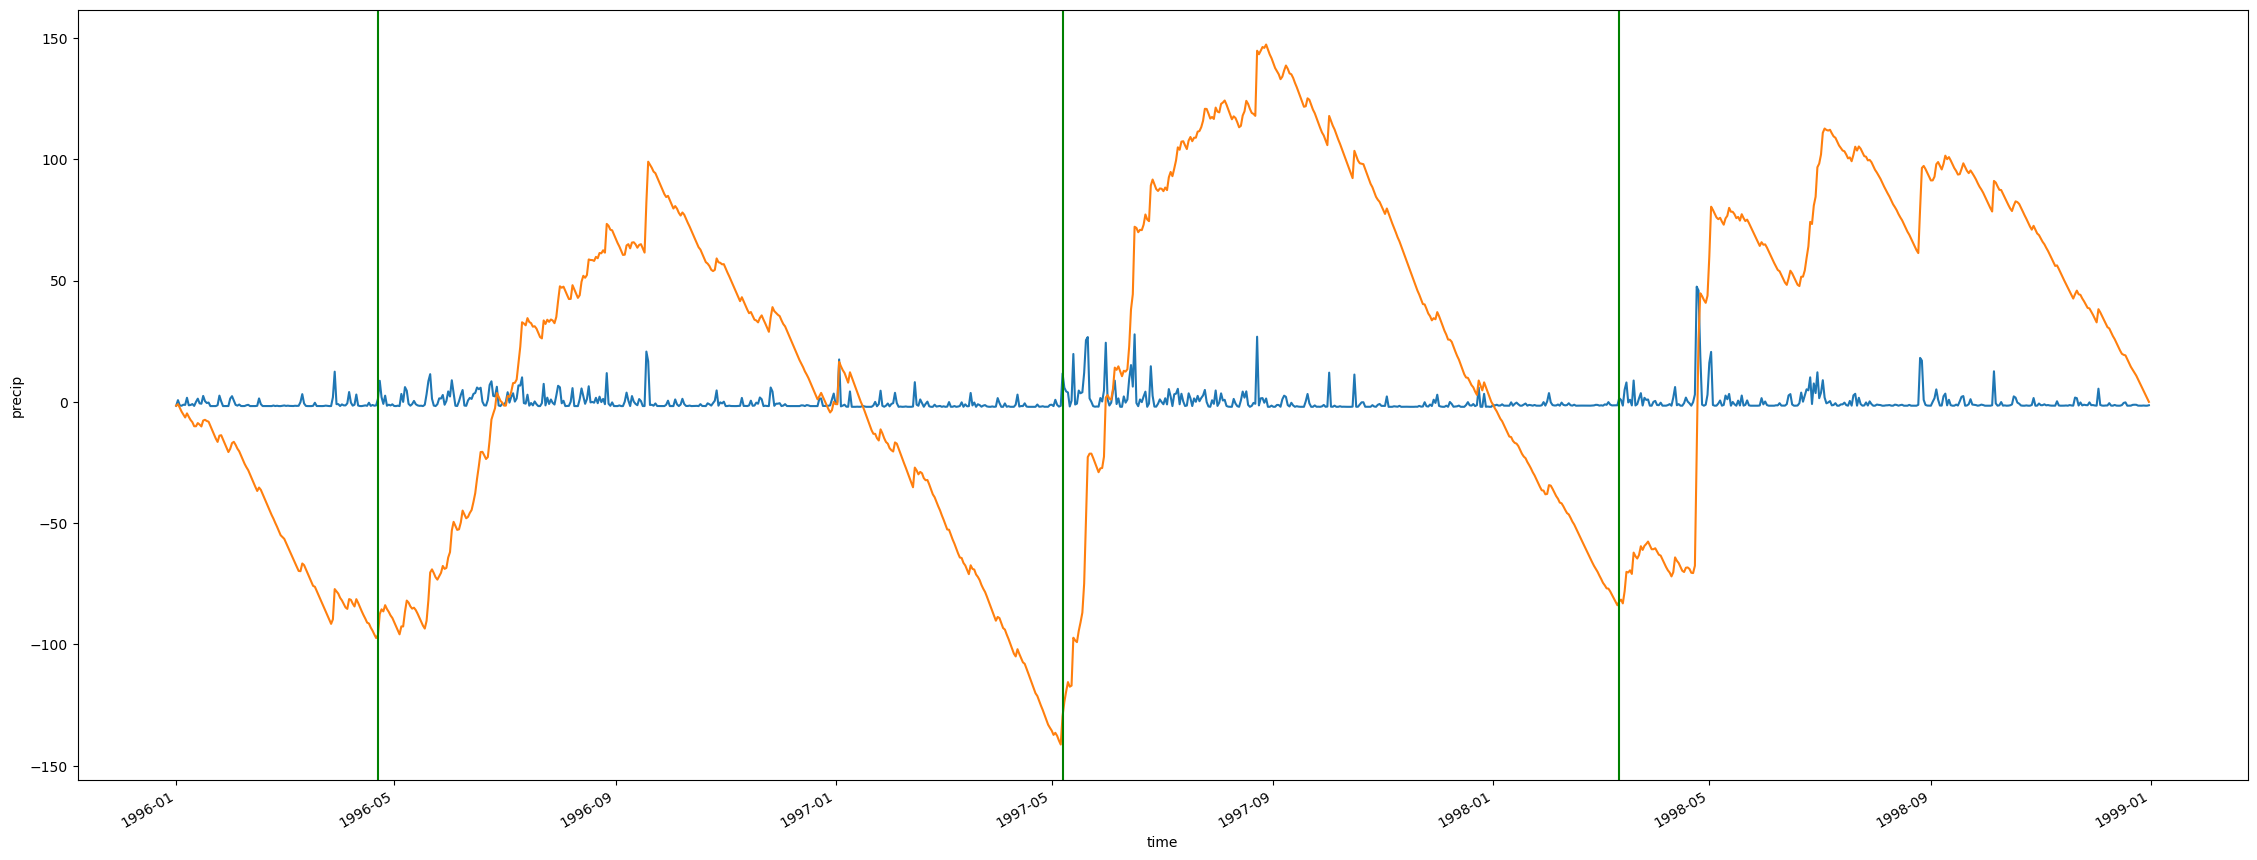

In [32]:
years_to_plot = [1996,1998]
years_slice = slice(str(years_to_plot[0]),str(years_to_plot[1]))
onset_to_plot = onset_dates[np.flatnonzero(np.isin(years_,np.arange(years_to_plot[0],years_to_plot[1]+1)))]
#demise_to_plot = demise_dates[np.flatnonzero(np.isin(years_,np.arange(years_to_plot[0],years_to_plot[1]+1)))]
input_data.sel(time=years_slice).plot(figsize=(28,10))
input_data.sel(time=years_slice).cumsum().plot()
for i in onset_to_plot:
    plt.axvline(i, color='green') 
#for j in demise_to_plot:
    #plt.axvline(j, color='brown') 

In [94]:
test_lm01[77]

126.0

In [ ]:
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')
map_proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)
#cmap = mpl.cm.RdBu_r


f, ax1 = plt.subplots(1, 1, figsize=(10, 13), dpi=600, subplot_kw={'projection': map_proj})
p = onset_data.dt.dayofyear.isel(year=50).plot.pcolormesh(ax=ax1,transform=ccrs.PlateCarree(), add_colorbar=False, cmap='viridis')


### Setting 1st plot parameters ###
ax1.coastlines(color='grey')
ax1.add_feature(cartopy.feature.BORDERS, color='black')
ax1.add_feature(cfeature.STATES, edgecolor='black')
#ax1.set_xticks(np.arange(-180,181, 40))
#ax1.set_yticks(np.arange(-90,91,15))
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
at = AnchoredText("a",
                      loc='upper left', prop=dict(size=8), frameon=True,)
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax1.add_artist(at)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05, axes_class=plt.Axes)
plt.colorbar(p, cax=cax)